In [1]:
!pip install tensorflow-text
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
!mkdir data
!unzip trainingandtestdata.zip

     |████████████████████████████████| 4.9 MB 12.6 MB/s 
--2021-11-30 11:25:50--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2021-11-30 11:25:50--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  19.4MB/s    in 4.9s    

2021-11-30 11:25:55 (15.8 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.16000

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from nltk.corpus import stopwords
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_csv("data/training.1600000.processed.noemoticon.csv",
                names=['polarity', 'id', 'date', 'query', 'user', 'text'],
                encoding='latin-1',
                usecols=['polarity', 'text'])

test_df = pd.read_csv("data/testdata.manual.2009.06.14.csv",
                names=['polarity', 'id', 'date', 'query', 'user', 'text'],
                encoding='latin-1',
                usecols=['polarity', 'text'])

test_df = test_df[test_df['polarity'] != 2]

In [7]:
# Remove tweets longer than 280 characters
df = df.drop(df[df.text.str.len() > 280].index).reset_index(drop=True)
test_df = test_df.drop(test_df[test_df.text.str.len() > 280].index).reset_index(drop=True)

# Convert to lowercase
df['text'] = df['text'].str.lower()
test_df['text'] = test_df['text'].str.lower()

# Remove URLs and @mentions
df['text'] = df['text'].apply(lambda t: re.sub('@[^ ]+|http[^ ]+', '', t).strip())
test_df['text'] = test_df['text'].apply(lambda t: re.sub('@[^ ]+|http[^ ]+', '', t).strip())

# Remove stopwords
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda t: ' '.join([w for w in t.split() if w not in stop]))
test_df['text'] = test_df['text'].apply(lambda t: ' '.join([w for w in t.split() if w not in stop]))

# Remove punctuation
df['text'] = df['text'].apply(lambda t: re.sub('[^a-zA-Z0-9\s]', '', t).strip())
test_df['text'] = test_df['text'].apply(lambda t: re.sub('[^a-zA-Z0-9\s]', '', t).strip())

# Replace label 4 with 1
df['polarity'] = df.polarity.replace(4,1)
test_df['polarity'] = test_df.polarity.replace(4,1)

In [8]:
train_df, remaining = train_test_split(df, train_size = 0.01, stratify = df['polarity'])
val_df, _ = train_test_split(remaining,train_size = 0.001, stratify = remaining['polarity'])

In [9]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['text'].values, train_df['polarity'].values))
  val_data = tf.data.Dataset.from_tensor_slices((val_df['text'].values, val_df['polarity'].values))
  test_data = tf.data.Dataset.from_tensor_slices((test_df['text'].values, test_df['polarity'].values))

In [10]:
bert_layer = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
tokenizer = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [11]:
with tf.device('/cpu:0'):
  train_data = train_data.batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE)
  val_data = val_data.batch(32, drop_remainder = True).prefetch(tf.data.experimental.AUTOTUNE)
  test_data = test_data.batch(32, drop_remainder = False).prefetch(tf.data.experimental.AUTOTUNE)

In [18]:
def create_model():
  
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)

  preprocessor = hub.KerasLayer(tokenizer)
  encoder_inputs = preprocessor(text_input)

  encoder = hub.KerasLayer(bert_layer, trainable=True)
  outputs = encoder(encoder_inputs)

  pooled_output = outputs['pooled_output']

  bnorm = tf.keras.layers.BatchNormalization()(pooled_output)
  dropout1 = tf.keras.layers.Dropout(0.4)(bnorm)
  fullyconnected1 = tf.keras.layers.Dense(128, activation='relu')(dropout1)
  dropout2 = tf.keras.layers.Dropout(0.4)(fullyconnected1)
  fullyconnected2 = tf.keras.layers.Dense(32, activation='relu')(dropout2)
  final_output = tf.keras.layers.Dense(1, activation='sigmoid')(fullyconnected2)
    
  return tf.keras.Model(text_input, final_output)

In [19]:
model = create_model()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])

In [20]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', min_delta=0.01, patience=2, restore_best_weights=True)

In [21]:
epochs = 10
history = model.fit(train_data, 
                    validation_data=val_data,
                    epochs=epochs,
                    callbacks=[callback], 
                    verbose=1)

Epoch 1/10
499/499 [==============================] - 801s 2s/step - loss: 0.6590 - binary_accuracy: 0.6663 - val_loss: 0.5039 - val_binary_accuracy: 0.7621
Epoch 2/10
499/499 [==============================] - 782s 2s/step - loss: 0.5087 - binary_accuracy: 0.7589 - val_loss: 0.4871 - val_binary_accuracy: 0.7736
Epoch 3/10
499/499 [==============================] - 782s 2s/step - loss: 0.4272 - binary_accuracy: 0.8092 - val_loss: 0.5144 - val_binary_accuracy: 0.7755
Epoch 4/10
499/499 [==============================] - 782s 2s/step - loss: 0.3258 - binary_accuracy: 0.8608 - val_loss: 0.5853 - val_binary_accuracy: 0.7761


In [22]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

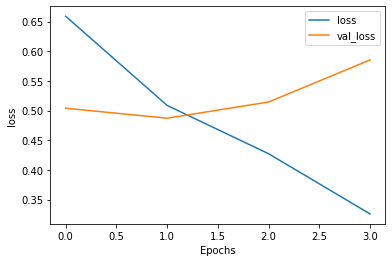

In [23]:
plot_graphs(history=history, metric='loss')

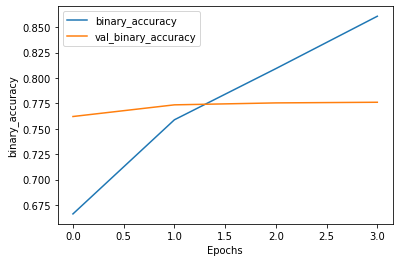

In [24]:
plot_graphs(history,'binary_accuracy')

In [36]:
y_true = test_df['polarity']
y_pred = model.predict(test_data)

y_pred = y_pred.flatten()

for i in range(len(y_pred)):
  if y_pred[i] < 0.5:
    y_pred[i] = 0
  else:
    y_pred[i] = 1

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.81      0.84       177
           1       0.83      0.87      0.85       182

    accuracy                           0.84       359
   macro avg       0.85      0.84      0.84       359
weighted avg       0.84      0.84      0.84       359

